<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/Zheng2007_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffHOD Examples
This notebook illustrates how to implement Zheng2007, and compare the results to halotools

## Preliminary setup


Here we download and install all the requirements

In [1]:
!nvidia-smi

Sat Oct 29 02:47:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   37C    P8     1W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

In [3]:
import tensorflow as tf
print("TF Version:", tf.__version__) #checked on 2.6.0

import tensorflow_probability as tfp
print("TFP Version:", tfp.__version__) #checked on 0.13.0 

import keras
print("Keras Version:", keras.__version__)
#note, Keras = 2.6.0 (shouldn't matter but it seems to cause errors)

TF Version: 2.6.0
TFP Version: 0.13.0
Keras Version: 2.6.0


In [5]:
%pylab inline
import numpy as np
tfd = tfp.distributions
tfb = tfp.bijectors
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from diffhod.utils import *

#Halotools to compare against

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib
2.6.0


## Prepare halo catalog

In [6]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

## Model definition

In [7]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [8]:
#fiducial HOD parameters
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [9]:
batch_size=1

#fiducial values
max_sat = 48
temperature=0.1

from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
import edward2 as ed

@tf.function
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,batch_size=batch_size, temperature = temperature):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [10]:
# sampling galaxies from the model

gal_cat = hod(tf_halocat)

2022-10-29 02:49:50.975836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

## Testing 2pt function

In [12]:
# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001
ht_cens = ht_sample[m]
ht_sats = ht_sample[~m]

In [13]:
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p].numpy()

In [14]:
p = gal_cat['n_sat']>0.5


In [15]:
tf_sats = tf.reshape(gal_cat['pos_sat'],(max_sat,-1,3))[p[:,:]].numpy().reshape((-1,3))
tf_sample = np.concatenate([tf_cens, tf_sats], axis=0)

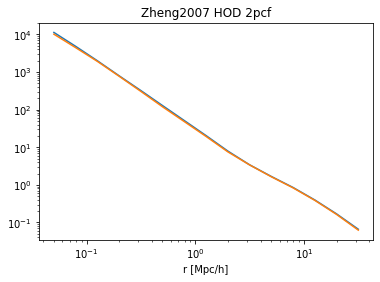

In [17]:
rbins = np.logspace(-1.5, 1.5, 16)
xi_ht = tpcf(ht_sample, rbins, period=halocat.Lbox)
xi_tf = tpcf(tf_sample, rbins, period=halocat.Lbox)

loglog(rbins[1:],xi_ht, label='halotools')
loglog(rbins[1:],xi_tf, label='DHOD')
xlabel('r [Mpc/h]')
title('Zheng2007 HOD 2pcf');

## Occupancy Distributions

Look to see how occupancy changes as a function of mass between Halotools and DiffHOD.

Very hacky implementation below! :D

In [18]:
import scipy


In [19]:
import copy 

new_params = copy.deepcopy(zheng07_model.param_dict)

In [20]:
out_sat = []
out_cen = []

binned_out_sat = scipy.stats.binned_statistic(np.log10(zheng07_model.mock.halo_table["halo_mvir"]),zheng07_model.mock.halo_table["halo_num_satellites"],bins=50)
binned_out_cen = scipy.stats.binned_statistic(np.log10(zheng07_model.mock.halo_table["halo_mvir"]),zheng07_model.mock.halo_table["halo_num_centrals"],bins=50)

for tau in [1,0.5,0.1,0.02]:
# sampling galaxies from the model
    gal_cat = hod(tf_halocat, temperature =tau)
    binned_out_sat_tf = scipy.stats.binned_statistic(np.log10(tf_halocat["halo_mvir"]),tf.reduce_sum(gal_cat['n_sat'],axis=0),bins=50)
    binned_out_cen_tf = scipy.stats.binned_statistic(np.log10(tf_halocat["halo_mvir"]),gal_cat['n_cen'],bins=50)

    out_sat.append(binned_out_sat_tf)
    out_cen.append(binned_out_cen_tf)

In [21]:
bins_a = [[] for i in range(-4,10)]


In [22]:
np.array(tf.reduce_sum(gal_cat['n_sat'],axis=0)).shape

(1033105,)

In [23]:
#binning DiffHOD results over 100 realizations (could probably use tf's batching to make this much faster)
for qqq in range(0,100):
    print(qqq)
    gal_cat = hod(tf_halocat)
    for i in range(-4,10):
        filtb = np.logical_and(tf_halocat["halo_mvir"]<10**(13+i*0.2 + 0.2),tf_halocat["halo_mvir"]>10**(13+i*0.2))
        #_,bins,_ = plt.hist(np.array(tf.reduce_sum(gal_cat['n_sat'],axis=0))[0][filtb],alpha=0.5,range=(0,20),bins=20)
        bins_a[i+4].append(np.array(tf.reduce_sum(gal_cat['n_sat'],axis=0))[filtb])
        
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
#Binning Halotools results over 100 realizations
bins_b = [[] for i in range(-4,10)]
for qqq in range(0,100):
    print(qqq)
    zheng07_model.populate_mock(halocat) 
    for i in range(-4,10):
        filt = np.logical_and(zheng07_model.mock.halo_table["halo_mvir"]<10**(13+i*0.2 + 0.2),zheng07_model.mock.halo_table["halo_mvir"]>10**(13+i*0.2))
        #_,bins,_ = plt.hist(np.array(tf.reduce_sum(gal_cat['n_sat'],axis=0))[0][filtb],alpha=0.5,range=(0,20),bins=20)
        bins_b[i+4].append(np.array(zheng07_model.mock.halo_table["halo_num_satellites"])[filt])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
np.sort(np.array(bins_b[i]).flatten())[int(1400*(50-18)/100)],np.sort(np.array(bins_b[i]).flatten())[int(1400*1/2)],np.sort(np.array(bins_b[i]).flatten())[int(1400*68/100)]

(2, 2, 3)

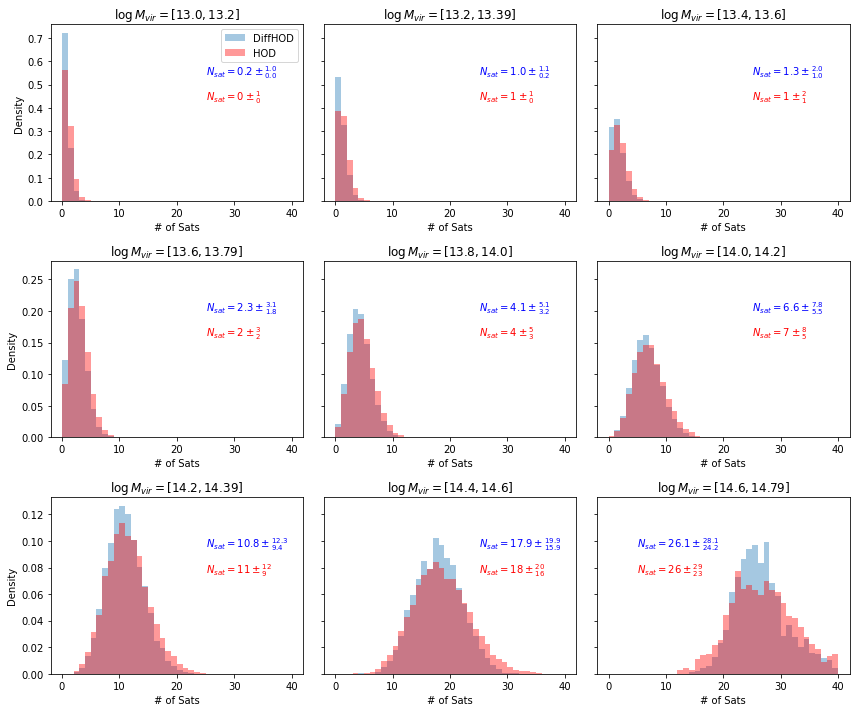

In [26]:
#plotting results

fig, ax = plt.subplots(3, 3,sharey="row")
fig.set_size_inches(12.0, 10.0)

for i in range(4,13):
    nn=i-4
   # print(i,nn,nn%3,nn-nn%3*3)
    if nn%3 == 0 :
        vals,bins,_ = ax[int(nn/3),nn%3].hist(np.array(bins_a[i]).flatten(),alpha=0.4,density=1.0,range=(0,40),bins=40,label="DiffHOD")
    else:
        _,bins,_ = ax[int(nn/3),nn%3].hist(np.array(bins_a[i]).flatten(),alpha=0.4,density=1.0,range=(0,40),bins=40,label="DiffHOD")

    ax[int(nn/3),nn%3].hist(np.array(bins_b[i]).flatten(),bins=bins,color="red",alpha=0.4,density=1.0,label="HOD")
    ax[int(nn/3),nn%3].set_title("$\log M_{vir} = [" + str(13+(i-4)*0.2)[:5]+ "," + str(13+(i-4)*0.2+0.2)[:5]+"]$",)
    ax[int(nn/3),nn%3].set_xlabel("# of Sats")
    if nn == 8:
        nni = np.sort(np.array(bins_b[i]).flatten()).shape[0]
        A,B,C = np.sort(np.array(bins_b[i]).flatten())[int(nni*(50-18)/100)],np.sort(np.array(bins_b[i]).flatten())[int(nni*1/2)],np.sort(np.array(bins_b[i]).flatten())[int(nni*68/100)]
        ax[int(nn/3),nn%3].text(5,vals.max()*3/5,r"$N_{sat} = " + str(B) + " \pm^{"+str(C)+"}_{"+str(A)+"}$",color="Red")
        nni = np.sort(np.array(bins_a[i]).flatten()).shape[0]
        A,B,C = np.sort(np.array(bins_a[i]).flatten())[int(nni*(50-18)/100)],np.sort(np.array(bins_a[i]).flatten())[int(nni*1/2)],np.sort(np.array(bins_a[i]).flatten())[int(nni*68/100)]
        ax[int(nn/3),nn%3].text(5,vals.max()*3/4,r"$N_{sat} = " + str(f"{B: .1f}") + " \pm^{"+str(f"{C: .1f}")+"}_{"+str(f"{A: .1f}")+"}$",color="Blue")
        
    else:
        nni = np.sort(np.array(bins_b[i]).flatten()).shape[0]
        A,B,C = np.sort(np.array(bins_b[i]).flatten())[int(nni*(50-18)/100)],np.sort(np.array(bins_b[i]).flatten())[int(nni*1/2)],np.sort(np.array(bins_b[i]).flatten())[int(nni*68/100)]
        ax[int(nn/3),nn%3].text(25,vals.max()*3/5,r"$N_{sat} = " + str(B) + " \pm^{"+str(C)+"}_{"+str(A)+"}$",color="Red")
        nni = np.sort(np.array(bins_a[i]).flatten()).shape[0]
        A,B,C = np.sort(np.array(bins_a[i]).flatten())[int(nni*(50-18)/100)],np.sort(np.array(bins_a[i]).flatten())[int(nni*1/2)],np.sort(np.array(bins_a[i]).flatten())[int(nni*68/100)]
        ax[int(nn/3),nn%3].text(25,vals.max()*3/4,r"$N_{sat} = " + str(f"{B: .1f}") + " \pm^{"+str(f"{C: .1f}")+"}_{"+str(f"{A: .1f}")+"}$",color="Blue")

ax[0,0].set_ylabel("Density")
ax[1,0].set_ylabel("Density")
ax[2,0].set_ylabel("Density")

ax[0,0].legend()
fig.tight_layout()
plt.savefig("distributions.pdf")
plt.show()

In [27]:
#pretty plot

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

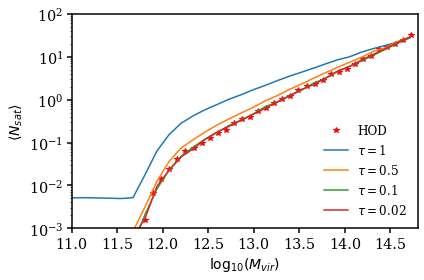

In [29]:
#ploting average satillite occupancy by halo mass as a temperature varries (tau = 0.1 works well!)

plt.plot((binned_out_sat.bin_edges[1:] + binned_out_sat.bin_edges[:-1])/2,binned_out_sat.statistic,"r*",label="HOD")

tt = [1,0.5,0.1,0.02]

for n,os in enumerate(out_sat):
    plt.plot((os.bin_edges[1:] + os.bin_edges[:-1])/2,os.statistic,label=r"$\tau = $" + str(tt[n]))
plt.legend(loc=4,fontsize=12)
plt.semilogy()
plt.ylabel(r"$\langle N_{sat} \rangle$",fontsize=14)
plt.xlabel(r"$\log_{10}(M_{vir})$",fontsize=14)
plt.ylim(0.001,100)
plt.xlim(11.0,14.80)
plt.tight_layout()
plt.savefig("occupancy_sat.pdf")


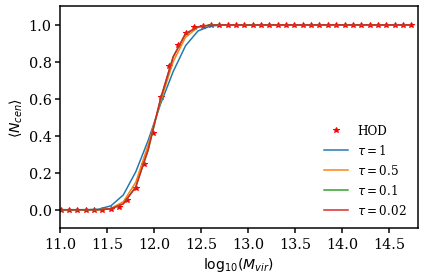

In [30]:
#ploting average central occupancy by halo mass as a temperature varries (tau = 0.1 works well!)

plt.plot((binned_out_cen.bin_edges[1:] + binned_out_cen.bin_edges[:-1])/2,binned_out_cen.statistic,"r*",label="HOD")

tt = [1,0.5,0.1,0.02]

for n,os in enumerate(out_cen):
    plt.plot((os.bin_edges[1:] + os.bin_edges[:-1])/2,os.statistic,label=r"$\tau = $" + str(tt[n]))
plt.legend(loc=4,fontsize=12)
#plt.semilogy()
plt.ylabel(r"$\langle N_{cen} \rangle$",fontsize=14)
plt.xlabel(r"$\log_{10}(M_{vir})$",fontsize=14)
plt.ylim(-0.1,1.1)
plt.xlim(11.0,14.80)
plt.tight_layout()

plt.savefig("occupancy_cen.pdf")


In [31]:
# choosing subvolume so we can play around easier with derivatives

# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]


halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [32]:

def nsat(x):
        logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
        tf_gal = hod(tf_halocat,logMmin,sigma_logM,logM0,logM1,alpha)
        a=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins,weights=tf.reduce_sum(tf_gal['n_sat'],axis=0))
        b=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins)
        return a/b
    
    

In [33]:
#for some reason I can't get derivatives of all bandpowers at once with this sort of setup and end up looping through them isntead...
#easier than debugging the grad function :D

fid_hod = [12.02, 0.26, 11.38, 13.31, 1.06]

tau_array = [0.02,0.1,1.0]
sat_array =[]

cen_array =[]
for tau in tau_array:
    print(tau)
    bins = tf.linspace(tf.math.reduce_min(np.log10(tf_halocat["halo_mvir"])), tf.math.reduce_max(np.log10(tf_halocat["halo_mvir"])), 50)

    def ncen(x):
        logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
        tf_gal = hod(tf_halocat,logMmin,sigma_logM,logM0,logM1,alpha, temperature = tau)
        a=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins,weights=tf_gal['n_cen'])
        b=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins)
        #print(a,b)
        return a/b


    def nsat(x):
        logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
        tf_gal = hod(tf_halocat,logMmin,sigma_logM,logM0,logM1,alpha, temperature = tau)
        a=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins,weights=tf.reduce_sum(tf_gal['n_sat'],axis=0))
        b=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins)
        return a/b
    
    #checking gradients...
    out_ar = []
    x = tf.Variable(fid_hod)
    #print(ncen(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
    #loss_ar.append(np.array(L))
    for nn in range(0,49):
        print(nn)
        def get_grads(x):
            with tf.GradientTape(persistent=True) as g:
             #  g.watch(x)
             #  print(nsat(x))
               L = nsat(x)[nn]
            #print(x)
            dL_dx = g.gradient(L, x)
            return dL_dx
        #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
        grad = get_grads(x)
        out_ar.append(np.array(grad))
       # print(nn,grad)
    sat_array.append(np.array(out_ar))
    out_ar = []
    #same for centrals
    x = tf.Variable(fid_hod)
   # print(ncen(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
    #loss_ar.append(np.array(L))
    for nn in range(0,49):
        def get_grads(x):
            with tf.GradientTape(persistent=True) as g:
             #  g.watch(x)
               L = ncen(x)[nn]
            dL_dx = g.gradient(L, x)
            return dL_dx
        #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
        grad = get_grads(x)
        out_ar.append(np.array(grad))
      #  print(nn,grad)
    cen_array.append(np.array(out_ar))


0.02
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [34]:
#analytical derivatives, from wolfram and/or by pencil/paper

def dncendlogmin(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    return -exp*10/(sigma_logM*np.sqrt(np.pi)*M)
    
def dncendsigma(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    return -exp*1/(sigma_logM**2.0*np.sqrt(np.pi)) * (M-logMmin)

def dnsatdlogmin(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    pref = ((10**M-10**logM0)/(10**logM1))**alpha
    return -exp*10/(sigma_logM*np.sqrt(np.pi)*M)*pref
    
def dnsatdsigma(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    pref = ((10**M-10**logM0)/(10**logM1))**alpha

    return -exp*1/(sigma_logM**2.0*np.sqrt(np.pi)) * (M-logMmin)*pref


def dnsatdalpha(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    pref = 1/2*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return pref *((10**M-10**logM0)/(10**logM1))**(alpha) * np.log((10**M-10**logM0)/(10**logM1))

def dnsatdlogM0(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    pref = 1/2*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return 1/2*pref *((10**M-10**logM0)/(10**logM1))**(alpha-1) * -1*alpha/logM1


def dnsatdlogM1(M):
    logMmin, sigma_logM, logM0, logM1, alpha = fid_hod
    pref = 10*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return pref *((10**M-10**logM0)/(10**logM1))**(alpha) * -1*alpha/logM1



5.539272774849919
5.539272774849919
5.539272774849919
5.539272774849919


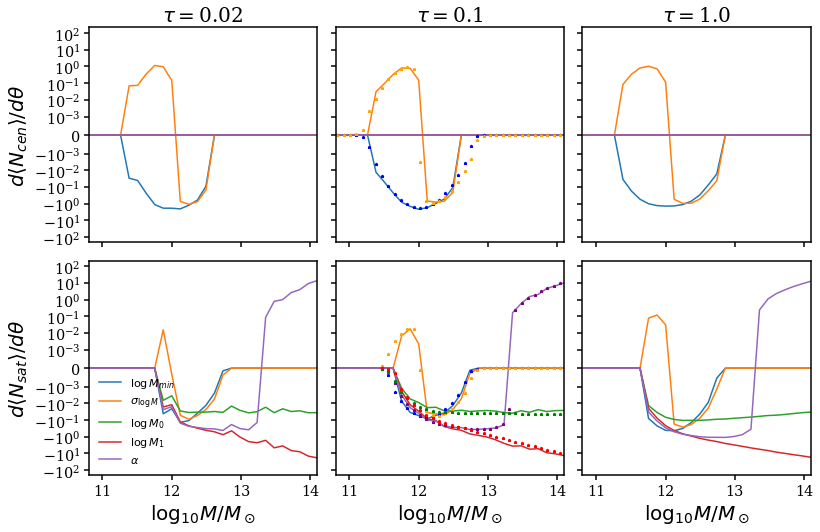

In [40]:

fig, ax = plt.subplots(2, 3,sharex=True,sharey=True)
fig.set_size_inches(11.5, 7.5)

ll = [r'$\logM_{min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']

ax[0,0].set_ylabel(r"$d\langle N_{cen} \rangle/d\theta$",fontsize=20)
ax[1,0].set_ylabel(r"$d\langle N_{sat} \rangle/d\theta$",fontsize=20)

for i,xx in enumerate(cen_array):
    for j in range(0,5):
        ax[0,i].plot((bins[1:]+bins[:-1])/2,xx[:,j],label = ll[j])  
    ax[0,i].set_xlim(10.8,14.1)
  #  ax[0,i].set_ylabel(r"$d\langle N_{sat} \rangle/d\theta$")
    ax[0,i].set_yscale('symlog', linthresh=0.0010)
    ax[0,i].set_title(r'$\tau = $' + str(tau_array[i]),fontsize=20)

for i,xx in enumerate(sat_array):
    for j in range(0,5):
        ax[1,i].plot((bins[1:]+bins[:-1])/2,xx[:,j],label = ll[j])
    ax[1,i].set_xlim(10.8,14.1)
    ax[1,i].set_yscale('symlog', linthresh=0.0010)
    ax[1,i].set_xlabel(r'$\log_{10} M/M_\odot$',fontsize=20)
    #ax[0,i].set_title(r'$\tau = $' + str(tau_array[i]))
    
ax[0,1].plot(np.linspace(10,14.5,50),dncendlogmin(np.linspace(10,14.5,50)),"b*",markersize=3)
ax[0,1].plot(np.linspace(10,14.5,50),dncendsigma(np.linspace(10,14.5,50)),"*",color="orange",markersize=3)

ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogmin(np.linspace(10,14.5,50)),"b*",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdsigma(np.linspace(10,14.5,50)),"*",color="orange",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdalpha(np.linspace(10,14.5,50)),"*",color="purple",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogM0(np.linspace(10,14.5,50)),"*",color="green",markersize=3)

ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogM1(np.linspace(10,14.5,50)),"*",color="red",markersize=3)

plt.subplots_adjust(wspace=0, hspace=0)

ax[1,0].legend(loc=3,fontsize=11.2)
 
plt.tight_layout()
plt.savefig("3panel.pdf")

## Derivatives of Power Spectra

In [41]:
from diffhod.mock_observables.pk import Power_Spectrum
box_size=128
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

In [42]:
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    batch_size = logMmin.shape[0]
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha,batch_size=batch_size))

#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]
  print(bs)
  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  rho = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)

  return rho



#TF2 compatable painter
@tf.function  #(experimental_relax_shapes=True)
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1], [1., 1, 0],
                      [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None:
      kernel = tf.multiply(tf.expand_dims(weight, axis=-1), kernel)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    b = tf.cast(b, tf.float32)
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    update = tf.scatter_nd(
        tf.reshape(neighboor_coords, (-1, 8, 4)), tf.reshape(kernel, (-1, 8)),
        [batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [44]:
def pkr_l(x):
            logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
            tf_gal = paint_galaxies(hod(tf_halocat,logMmin, sigma_logM, logM0, logM1, alpha,batch_size=batch_size))
            output = PS.pk_tf(tf_gal)
            pkr = output[1]
            print(pkr.shape)
            return pkr[0]
#testing function...
x = tf.Variable([fid_hod])
print(pkr_l(x))

(1, 61)
tf.Tensor(
[0.08962674 0.07863984 0.05618515 0.04387514 0.03746184 0.03022684
 0.02404322 0.02440994 0.02006152 0.01927403 0.01748365 0.01652078
 0.01594935 0.01373114 0.01365721 0.01257142 0.01186082 0.01134349
 0.01085829 0.01063995 0.01021206 0.00981754 0.00911935 0.00877465
 0.00840588 0.00785539 0.00762712 0.00735068 0.00708942 0.00674898
 0.00646292 0.0062045  0.00589901 0.00563438 0.00561331 0.0053006
 0.00497289 0.00482073 0.00469847 0.00442028 0.00419679 0.00409163
 0.00387794 0.00372053 0.00354786 0.00335713 0.00322904 0.00315001
 0.00297898 0.00286082 0.00272223 0.00263905 0.00248938 0.00241942
 0.00228671 0.00221593 0.00212472 0.0020257  0.0019929  0.00190608
 0.00182145], shape=(61,), dtype=float32)


In [45]:
#checking gradients... again doesn't seem to broadcast in the nicest way so have to loop over bandpowers.
temp_array = []
for temp in tau_array:
    print(temp)
    grad_array = []
    for i in range(0,61):
        def pkr_l(x):
            logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
            tf_gal = paint_galaxies(hod(tf_halocat,logMmin, sigma_logM, logM0, logM1, alpha,temperature = temp, batch_size=batch_size))
            output = PS.pk_tf(tf_gal)
            pkr = output[1]
            print(pkr.shape)
            return pkr[0][i]

        x = tf.Variable([fid_hod])
        print(pkr_l(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
        #loss_ar.append(np.array(L))
        def get_grads(x):
            with tf.GradientTape(persistent=True) as g:
             #  g.watch(x)
               L = pkr_l(x)
            dL_dx = g.gradient(L, x)
            return dL_dx
        #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
        grad = get_grads(x)
        print(i,grad)
        grad_array.append(grad)
    temp_array.append(np.array(grad_array))

0.02
(1, 61)
tf.Tensor(0.09375199, shape=(), dtype=float32)
(1, 61)
0 tf.Tensor([[-0.19827105  0.09465048 -0.00420735 -0.16274716  0.03776518]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.07712925, shape=(), dtype=float32)
(1, 61)
1 tf.Tensor([[-0.13688435  0.06843816 -0.00163953 -0.09611472  0.03974324]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.056470826, shape=(), dtype=float32)
(1, 61)
2 tf.Tensor([[-0.15095708  0.03799185 -0.00118165 -0.06813218  0.03118893]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.04521701, shape=(), dtype=float32)
(1, 61)
3 tf.Tensor([[-0.09146631  0.01995442 -0.00130299 -0.05675444  0.01683301]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.03671335, shape=(), dtype=float32)
(1, 61)
4 tf.Tensor([[-0.08193594  0.02277483 -0.00182955 -0.05800504  0.01622002]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.03056044, shape=(), dtype=float32)
(1, 61)
5 tf.Tensor([[-0.04336918  0.01020009 -0.00053004 -0.05204817  0.02884021]], shape=(1,

(1, 61)
tf.Tensor(0.0030184633, shape=(), dtype=float32)
(1, 61)
48 tf.Tensor(
[[-3.7165028e-03  5.3925847e-04 -9.8807090e-05 -4.9681435e-03
   1.7454553e-03]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.002815882, shape=(), dtype=float32)
(1, 61)
49 tf.Tensor(
[[-3.6881496e-03  8.3293876e-04 -9.3928858e-05 -4.9802894e-03
   1.5438299e-03]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.002741543, shape=(), dtype=float32)
(1, 61)
50 tf.Tensor(
[[-3.1985277e-03  6.7285483e-04 -8.5753891e-05 -4.0651262e-03
   1.1521115e-03]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0026778497, shape=(), dtype=float32)
(1, 61)
51 tf.Tensor([[-0.00318569  0.00099461 -0.00010518 -0.00424511  0.0011698 ]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0024386917, shape=(), dtype=float32)
(1, 61)
52 tf.Tensor(
[[-2.3253539e-03  7.1634585e-04 -7.1294467e-05 -4.8310156e-03
   2.3406604e-03]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0023113373, shape=(), dtype=float32)
(1, 61)
53 tf

(1, 61)
tf.Tensor(0.0056050834, shape=(), dtype=float32)
(1, 61)
34 tf.Tensor([[-0.00630953  0.00104644 -0.00019735 -0.01058681  0.00423361]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0052186092, shape=(), dtype=float32)
(1, 61)
35 tf.Tensor([[-0.00647119  0.00167003 -0.00017777 -0.01071082  0.00477858]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.005067042, shape=(), dtype=float32)
(1, 61)
36 tf.Tensor([[-0.0060625   0.00112492 -0.00016214 -0.00931085  0.00391186]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0048072226, shape=(), dtype=float32)
(1, 61)
37 tf.Tensor([[-0.00617537  0.00093139 -0.00017798 -0.00895461  0.0037749 ]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0045676576, shape=(), dtype=float32)
(1, 61)
38 tf.Tensor([[-0.00557901  0.00086078 -0.00013883 -0.0084408   0.00352053]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.0044165473, shape=(), dtype=float32)
(1, 61)
39 tf.Tensor([[-0.00531122  0.00068669 -0.00013947 -0.00769243  0.00315979]]

(1, 61)
tf.Tensor(0.02128609, shape=(), dtype=float32)
(1, 61)
20 tf.Tensor([[-0.02087351  0.00249909 -0.00153689 -0.04458639  0.00314381]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.020280704, shape=(), dtype=float32)
(1, 61)
21 tf.Tensor([[-0.01930663  0.00206185 -0.00144246 -0.04366864  0.00437585]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.019224001, shape=(), dtype=float32)
(1, 61)
22 tf.Tensor([[-0.01710514  0.00123705 -0.00133963 -0.03949962  0.00336357]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.018083086, shape=(), dtype=float32)
(1, 61)
23 tf.Tensor([[-0.01616282  0.00147344 -0.00122931 -0.03847751  0.00395542]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.017124522, shape=(), dtype=float32)
(1, 61)
24 tf.Tensor([[-0.01639701  0.00200514 -0.00118273 -0.03544986  0.0026689 ]], shape=(1, 5), dtype=float32)
(1, 61)
tf.Tensor(0.01616771, shape=(), dtype=float32)
(1, 61)
25 tf.Tensor([[-0.01426114  0.00173483 -0.00110573 -0.03398241  0.00292653]], shape

In [46]:
out_array = np.array(temp_array)

In [47]:
out_array.shape

(3, 61, 1, 5)

In [48]:
x = tf.Variable([[12.02,  0.26, 11.38, 13.31,  0000001.06]])

#xd = tf.Variable([12.02,  0.26, 11.38, 13.31,  0000001.06])
xd1 = tf.Variable([[12.02+0.2,  0.26, 11.38, 13.31,  0000001.06]])
xd2 = tf.Variable([[12.02,  0.26+0.2, 11.38, 13.31,  0000001.06]])
xd3 = tf.Variable([[12.02,  0.26, 11.38+0.2, 13.31,  0000001.06]])
xd4 = tf.Variable([[12.02,  0.26, 11.38, 13.31+0.2,  0000001.06]])
xd5 = tf.Variable([[12.02,  0.26, 11.38, 13.31,  0000001.06+0.2]])


In [49]:
def pkr_l(x):
            logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
            tf_gal = paint_galaxies(hod(tf_halocat,logMmin, sigma_logM, logM0, logM1, alpha,batch_size=batch_size))
            output = PS.pk_tf(tf_gal)
            pkr = output[1]
            print(pkr.shape)
            return pkr[0]
        

In [50]:
logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(tf.Variable([fid_hod]))
tf_gal = paint_galaxies(hod(tf_halocat,logMmin, sigma_logM, logM0, logM1, alpha,batch_size=batch_size))

output = PS.pk_tf(tf_gal)

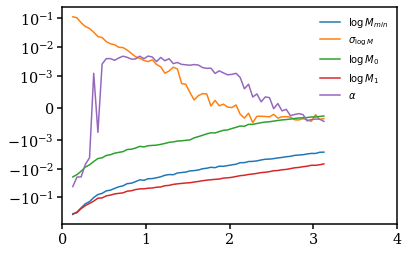

(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)
(1, 61)


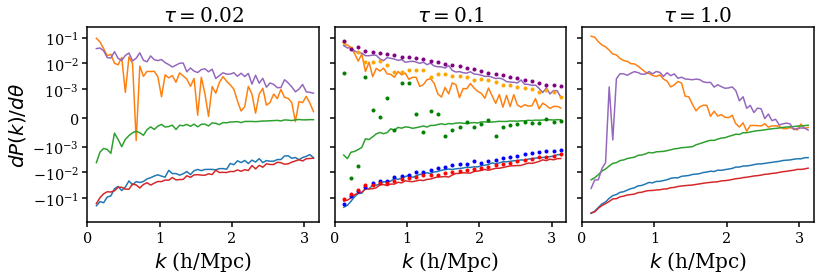

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
ll = [r'$\logM_{min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']
for i in range(5):
    plt.plot(output[0],out_array[2][:,0,i],label=ll[i])
    plt.yscale('symlog', linthresh=0.0010)

legend()
plt.xlim(0,4)

show()


fig, ax = plt.subplots(1, 3,sharex=True,sharey=True)
fig.set_size_inches(11.5, 4.0)

ll = [r'$\logM_{min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']

ax[0].set_ylabel(r"$d\langle N_{cen} \rangle/d\theta$",fontsize=20)

for i,xx in enumerate(out_array):
    for j in range(0,5):
        ax[i].plot(output[0],xx[:,0,j],label = ll[j])    
    ax[i].set_xlim(0,3.2)
  #  ax[0,i].set_ylabel(r"$d\langle N_{sat} \rangle/d\theta$")
    ax[i].set_yscale('symlog', linthresh=0.0010)
    ax[i].set_title(r'$\tau = $' + str(tau_array[i]),fontsize=20)
    ax[i].set_xlabel(r"$k$ (h/Mpc)",fontsize=20)

ax[1].plot(output[0][::2],-(pkr_l(x)[::2]-pkr_l(xd1)[::2])/0.2,"b.")
ax[1].plot(output[0][::2],-(pkr_l(x)[::2]-pkr_l(xd2)[::2])/0.2,".",color="orange")
ax[1].plot(output[0][::2],-(pkr_l(x)[::2]-pkr_l(xd3)[::2])/0.2,"g.")
ax[1].plot(output[0][::2],-(pkr_l(x)[::2]-pkr_l(xd4)[::2])/0.2,"r.")
ax[1].plot(output[0][::2],-(pkr_l(x)[::2]-pkr_l(xd5)[::2])/0.2,".",color="purple")
#Note Green Numerical Derivatives are kinda unstable with this approah

ax[0].set_ylabel(r"$dP(k)/d\theta$")
plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.savefig("ps_comparison.pdf")

#ax[-1].legend(loc=5)